# 데이터 로딩

In [1]:
# 데이터 분석
import pandas as pd
import numpy as np
import random as rnd

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 기계 학습
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
# 데이터 로딩
train = pd.read_csv('./data_bike/train.csv')
test = pd.read_csv('./data_bike/test.csv')

In [3]:
#데이터 확인
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 데이터 시각화 및 전처리

In [4]:
#datetimed을 시간 단위 별로 구분
train['datetime']=pd.to_datetime(train['datetime'])
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour
train['min']=train['datetime'].dt.minute
train['sec']=train['datetime'].dt.second
train['dayofweek']=train['datetime'].dt.dayofweek
train[['datetime','year','month','day','hour','min','sec','dayofweek']].head()

,datetime,year,month,day,hour,min,sec,dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,2011,1,1,4,0,0,5


In [5]:
#season 오류 수정
train['cor_season']=train['season']
for i in range(train.shape[0]):
    if train.loc[i, 'month'] in [3, 4, 5]:
        train.loc[i, 'cor_season']=1
    elif train.loc[i, 'month'] in [6,7,8]:
        train.loc[i, 'cor_season']=2
    elif train.loc[i, 'month'] in [9,10,11]:
        train.loc[i, 'cor_season']=3
    elif train.loc[i, 'month'] in [12,1,2]:
        train.loc[i, 'cor_season']=4

In [6]:
#weather가 4인 것이 하나 밖에 없으므로 행 삭제
#train[train['weather']==4]
#train=train.drop([5631])

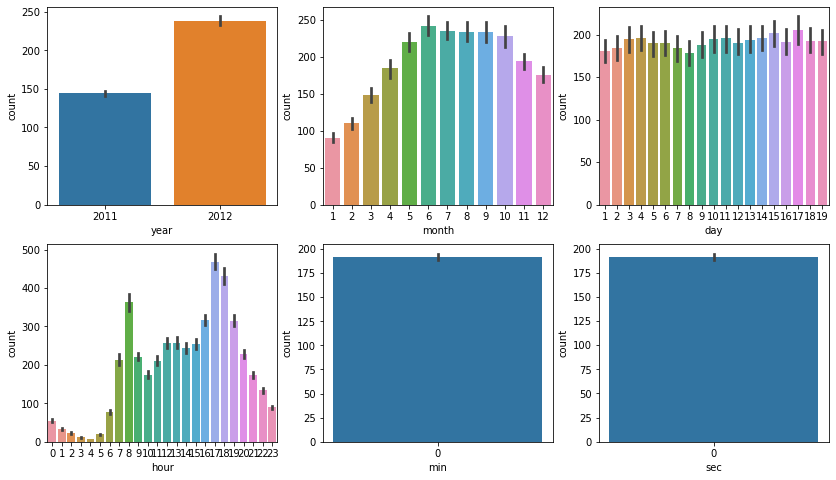

In [7]:
#시간별 바이크 대여 수 시각화
figure, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(14,8)
sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='min', y='count', ax=ax5)
sns.barplot(data=train, x='sec', y='count', ax=ax6)

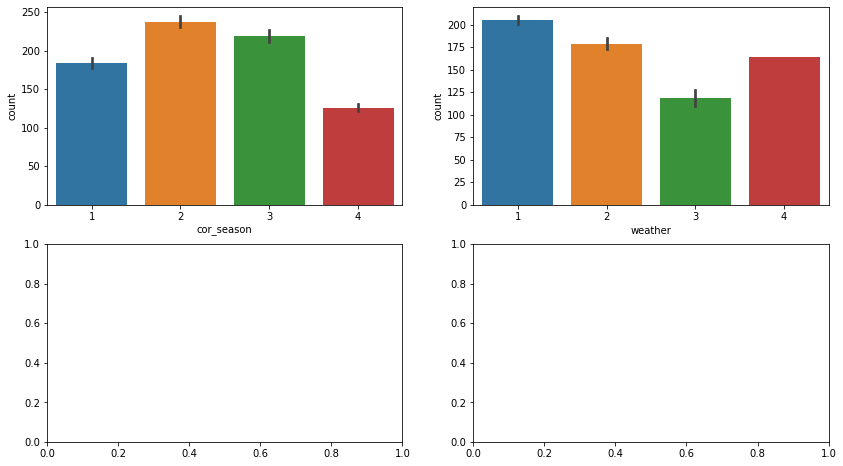

In [8]:
#시간별 바이크 대여 수 시각화2
figure, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,8)
sns.barplot(data=train, x='cor_season', y='count', ax=ax1)
sns.barplot(data=train, x='weather', y='count', ax=ax2)

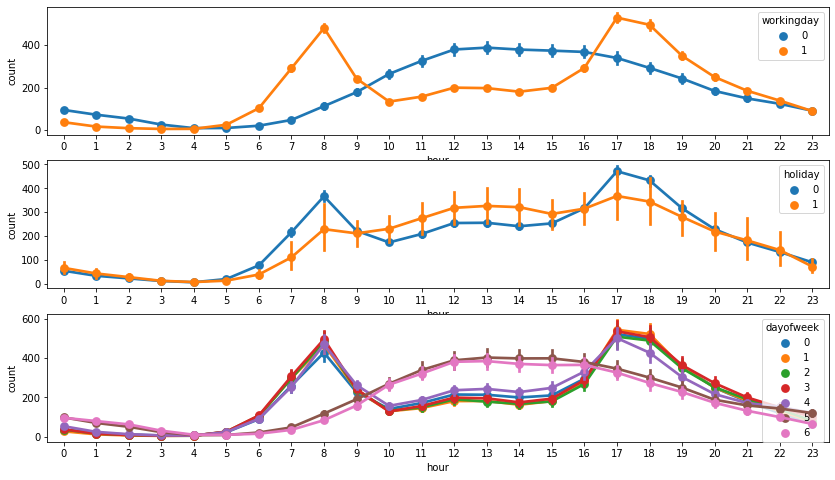

In [9]:
#근무일, 휴일, 요일을 시간단위 별로 시각화
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(14,8)
sns.pointplot(data = train, x='hour', y='count', hue = 'workingday', ax=ax1)
sns.pointplot(data = train, x='hour', y='count', hue = 'holiday', ax=ax2)
sns.pointplot(data = train, x='hour', y='count', hue = 'dayofweek', ax=ax3)

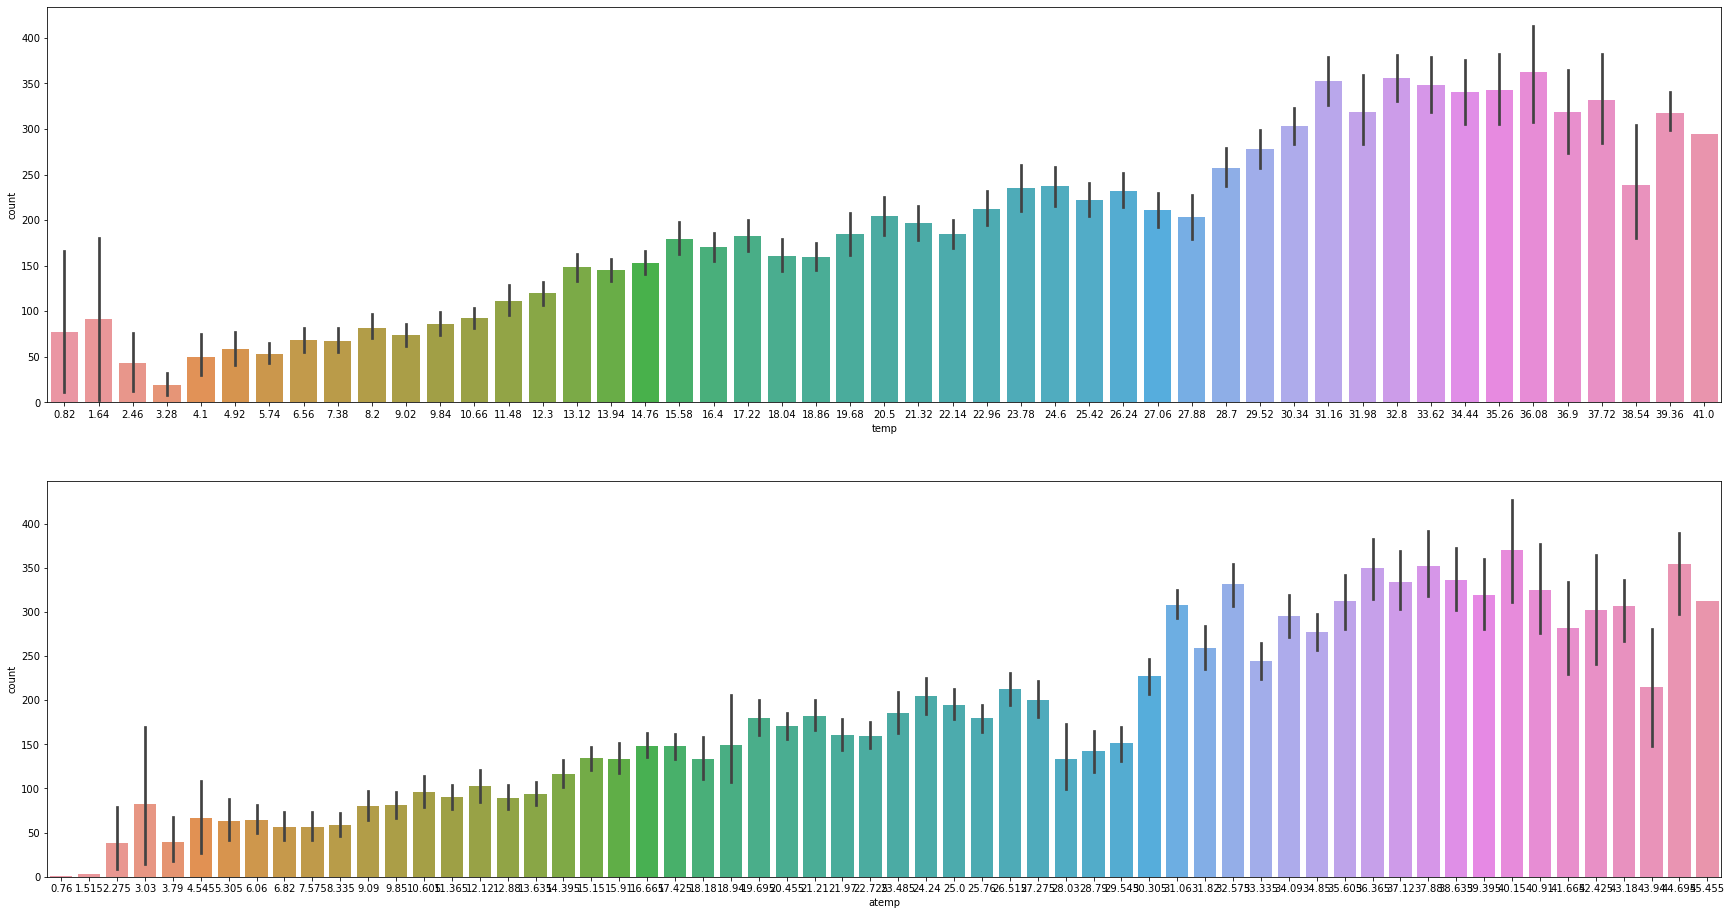

In [10]:
#온도, 체감온도 시각화
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(30,16)
sns.barplot(data=train, x='temp', y='count', ax=ax1)
sns.barplot(data=train, x='atemp', y='count', ax=ax2)

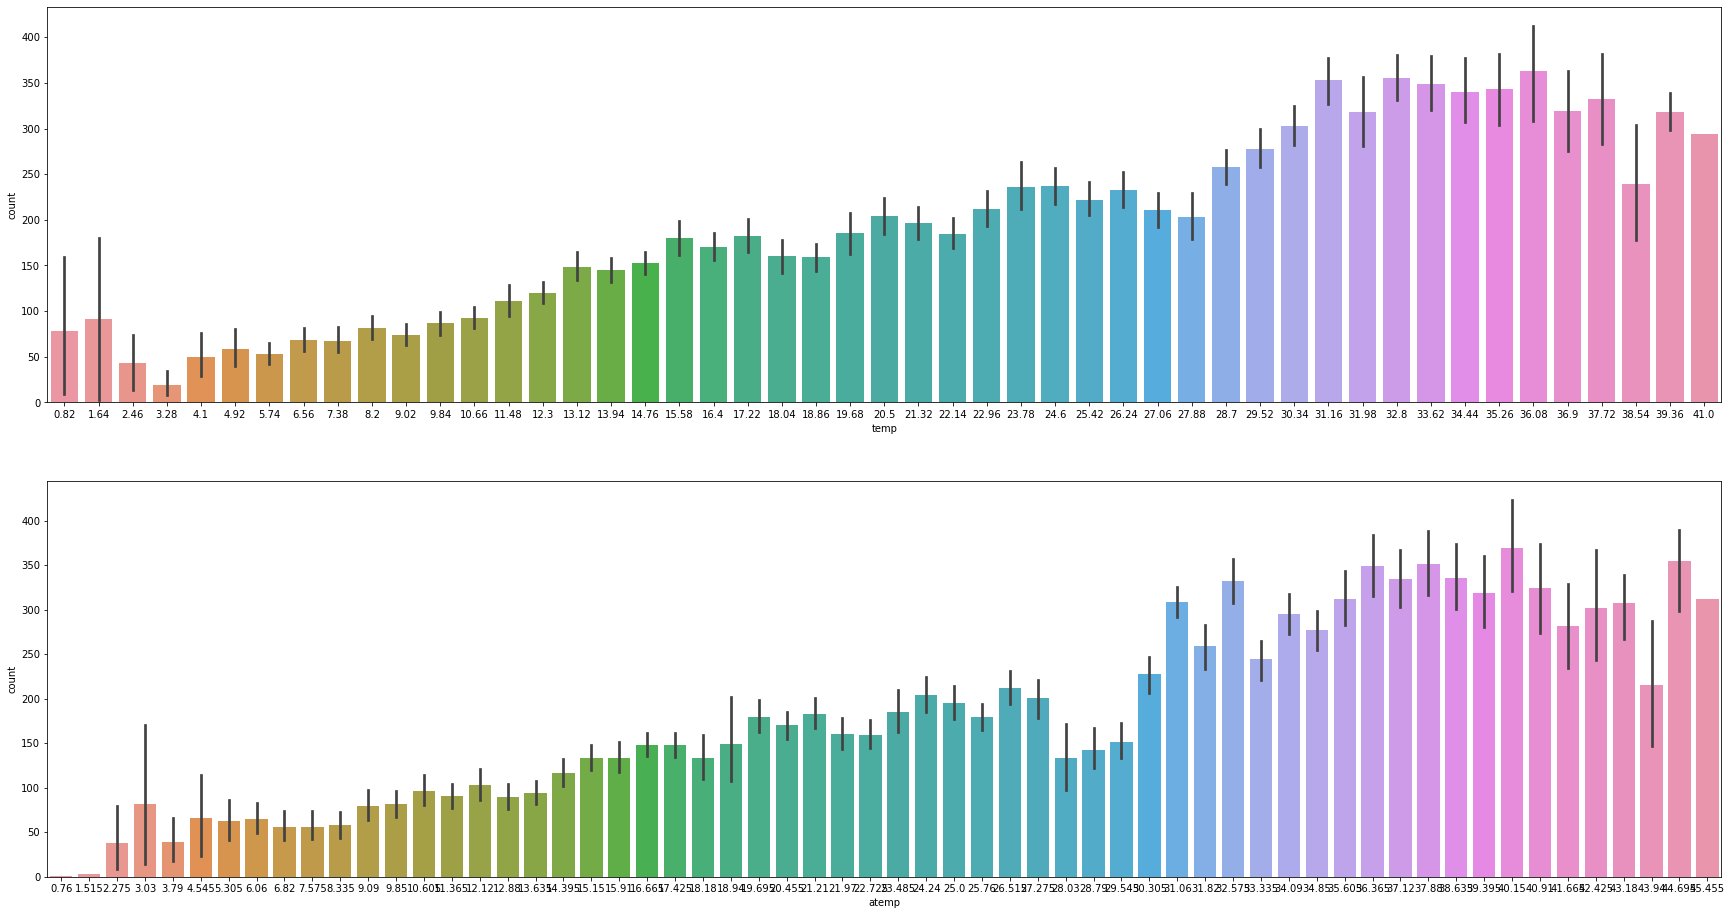

In [11]:
#dayofweek, holiday, workingday와 temp 
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(30,16)
sns.barplot(data=train, x='temp', y='count', ax=ax1)
sns.barplot(data=train, x='atemp', y='count', ax=ax2)

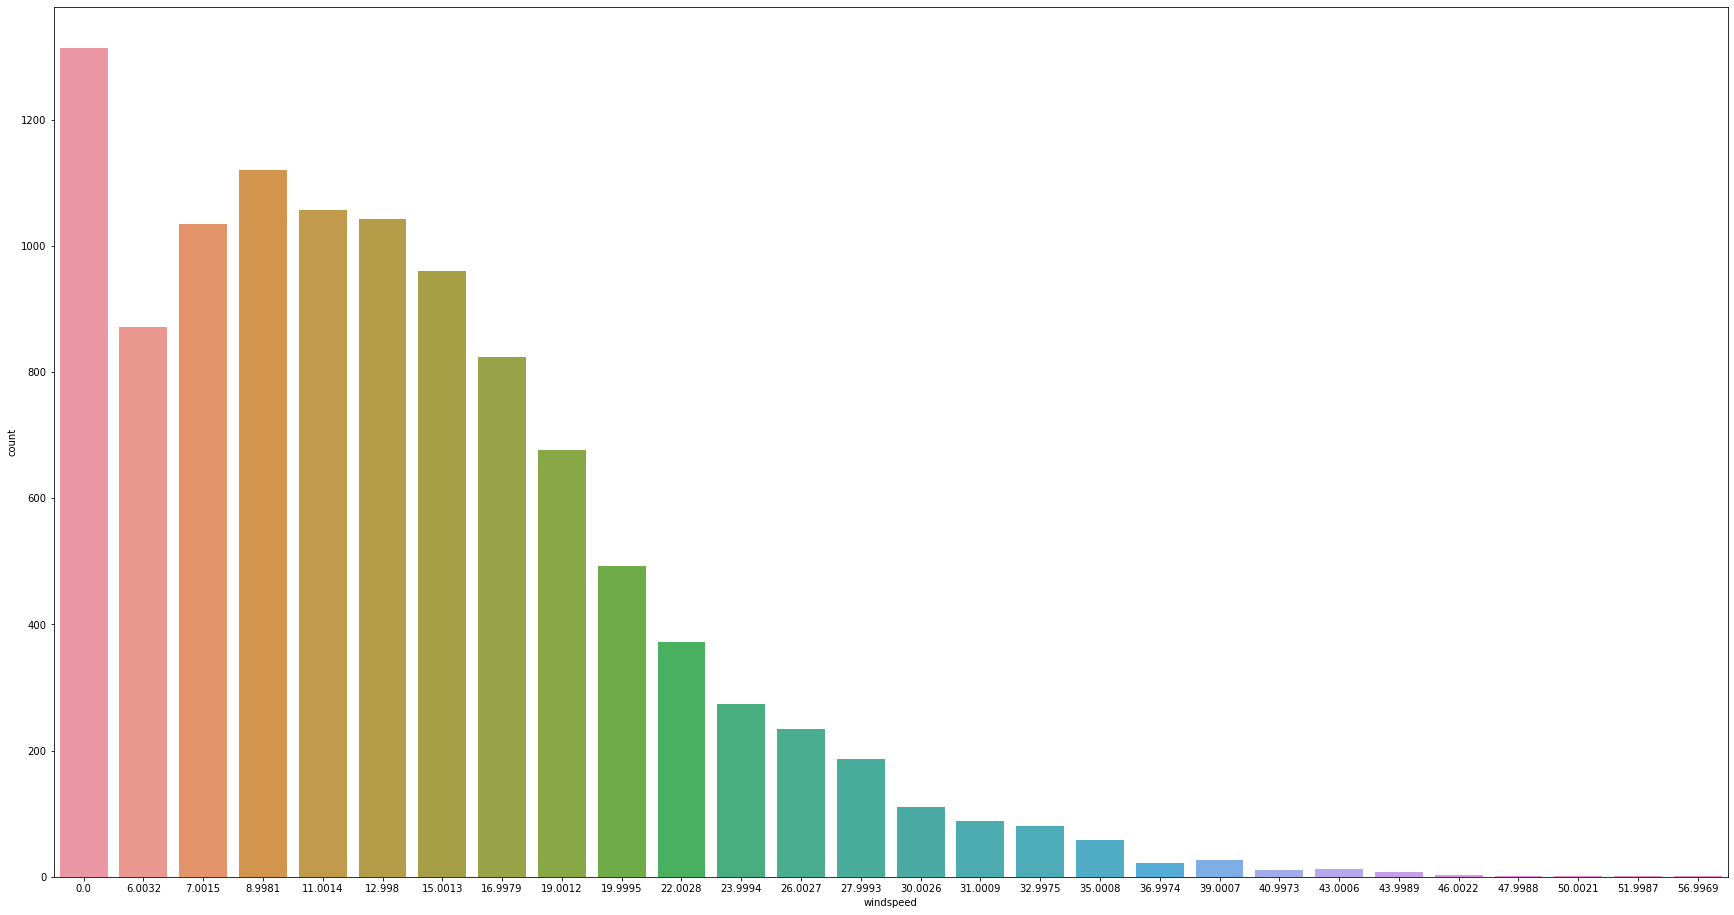

In [12]:
figure, (ax1) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(30,16)
sns.countplot(x='windspeed',data=train, ax=ax1)

# windspeed 모델링

In [13]:
windspeed_zero = train[train['windspeed'] == 0]
windspeed_notzero = train[train['windspeed'] != 0]

In [14]:
windspeed_x_train = windspeed_notzero[['temp','weather','humidity','month','hour','year']]
windspeed_y_train = windspeed_notzero['windspeed']
windspeed_x_test = windspeed_zero[['temp','weather','humidity','month','hour','year']]
windspeed_x_train.head()

,temp,weather,humidity,month,hour,year
5,9.84,2,75,1,5,2011
10,15.58,1,76,1,10,2011
11,14.76,1,81,1,11,2011
12,17.22,1,77,1,12,2011
13,18.86,2,72,1,13,2011


In [15]:
#xgboost를 이용한 회귀 분석
windspeed_xgb= XGBRegressor(n_estimators=500, max_depth=10)
windspeed_xgb.fit(windspeed_x_train, windspeed_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
#xgboost 정확도
acc_xgb = round(windspeed_xgb.score(windspeed_x_train, windspeed_y_train) * 100, 2)
acc_xgb

97.33

In [17]:
windspeed_zero['windspeed']=windspeed_xgb.predict(windspeed_x_test)

c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
windspeed=pd.concat([windspeed_zero, windspeed_notzero], axis=0)['windspeed']
train['windspeed']=windspeed
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,min,sec,dayofweek,cor_season
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,16.100897,3,13,16,2011,1,1,0,0,0,5,4
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,16.561098,8,32,40,2011,1,1,1,0,0,5,4
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,17.553900,5,27,32,2011,1,1,2,0,0,5,4
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,2.504247,3,10,13,2011,1,1,3,0,0,5,4
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,2.039808,0,1,1,2011,1,1,4,0,0,5,4


In [19]:
train['windspeed'].value_counts()

8.998100     1120
11.001400    1057
12.998000    1042
7.001500     1034
15.001300     961
             ... 
6.957885        1
11.915890       1
5.582994        1
14.916021       1
20.328783       1
Name: windspeed, Length: 1312, dtype: int64

# 속성 선택

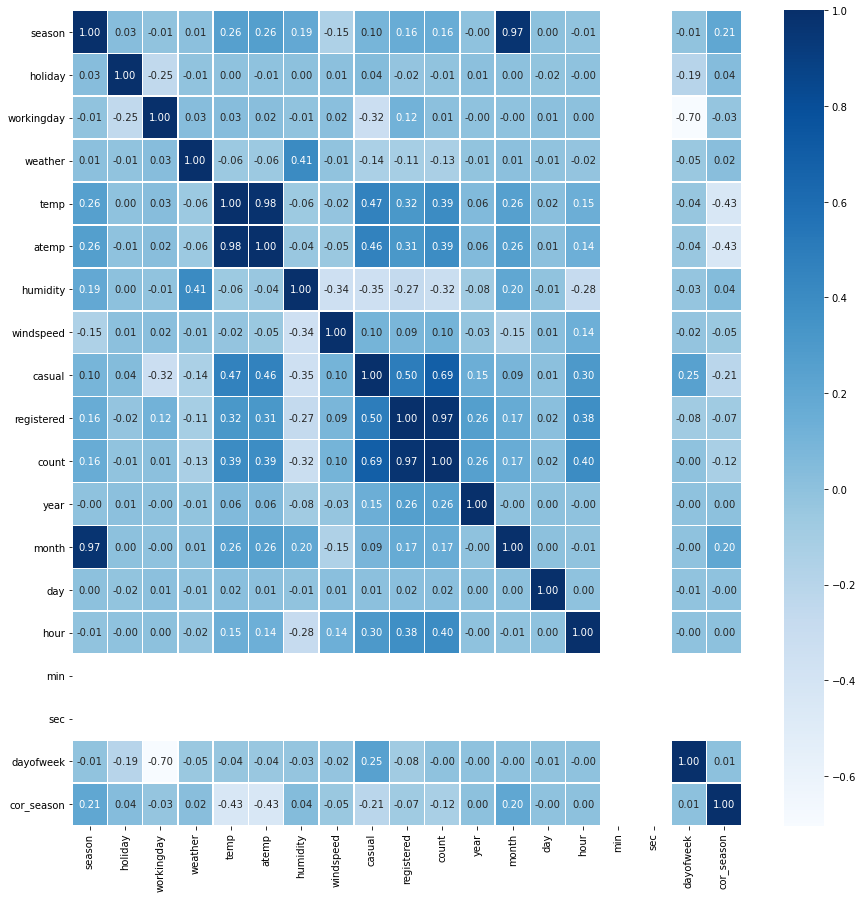

In [20]:
#각 속성 상관관계 히트맵으로 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [21]:
#상관관계 분석결과 불필요한 속성 삭제
train.drop(['datetime','season','min','sec','casual','registered'], axis=1, inplace=True)

In [22]:
train.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek,cor_season
0,0,0,1,9.84,14.395,81,16.100897,16,2011,1,1,0,5,4
1,0,0,1,9.02,13.635,80,16.561098,40,2011,1,1,1,5,4
2,0,0,1,9.02,13.635,80,17.553900,32,2011,1,1,2,5,4
3,0,0,1,9.84,14.395,75,2.504247,13,2011,1,1,3,5,4
4,0,0,1,9.84,14.395,75,2.039808,1,2011,1,1,4,5,4


# 테스트 데이터 전처리

In [23]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [24]:
#datetimed을 시간 단위 별로 구분
test['datetime']=pd.to_datetime(test['datetime'])
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['day']=test['datetime'].dt.day
test['hour']=test['datetime'].dt.hour
test['min']=test['datetime'].dt.minute
test['sec']=test['datetime'].dt.second
test['dayofweek']=test['datetime'].dt.dayofweek
test[['datetime','year','month','day','hour','min','sec','dayofweek']].head()

,datetime,year,month,day,hour,min,sec,dayofweek
0,2011-01-20 00:00:00,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,2011,1,20,4,0,0,3


In [25]:
#season 오류 수정
test['cor_season']=test['season']
for i in range(test.shape[0]):
    if test.loc[i, 'month'] in [3, 4, 5]:
        test.loc[i, 'cor_season']=1
    elif test.loc[i, 'month'] in [6,7,8]:
        test.loc[i, 'cor_season']=2
    elif test.loc[i, 'month'] in [9,10,11]:
        test.loc[i, 'cor_season']=3
    elif test.loc[i, 'month'] in [12,1,2]:
        test.loc[i, 'cor_season']=4

In [26]:
#테스트 데이터도 동일한 방법으로 모델링을 windspeed 재정의
windspeed_zero_test = test[test['windspeed'] == 0]
windspeed_notzero_test = test[test['windspeed'] != 0]
windspeed_x_test = windspeed_notzero_test[['temp','weather','humidity','month','hour','year']]
windspeed_y_test = windspeed_notzero_test['windspeed']
windspeed_x_test_test = windspeed_zero_test[['temp','weather','humidity','month','hour','year']]
windspeed_xgb_test= XGBRegressor(n_estimators=500, max_depth=10)
windspeed_xgb_test.fit(windspeed_x_test, windspeed_y_test)
windspeed_zero_test['windspeed']=windspeed_xgb.predict(windspeed_x_test_test)
windspeed_test=pd.concat([windspeed_zero_test, windspeed_notzero_test], axis=0)['windspeed']
test['windspeed']=windspeed_test
test.head()

c:\users\user\pycharmprojects\githubassign\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,min,sec,dayofweek,cor_season
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,2011,1,20,0,0,0,3,4
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,8.997417,2011,1,20,1,0,0,3,4
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,5.998957,2011,1,20,2,0,0,3,4
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,3,0,0,3,4
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.001400,2011,1,20,4,0,0,3,4


In [27]:
#불필요 속성 삭제
test.drop(['datetime','season','min','sec'], axis=1, inplace=True)

In [28]:
test.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,cor_season
0,0,1,1,10.66,11.365,56,26.002700,2011,1,20,0,3,4
1,0,1,1,10.66,13.635,56,8.997417,2011,1,20,1,3,4
2,0,1,1,10.66,13.635,56,5.998957,2011,1,20,2,3,4
3,0,1,1,10.66,12.880,56,11.001400,2011,1,20,3,3,4
4,0,1,1,10.66,12.880,56,11.001400,2011,1,20,4,3,4


# 모델링

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

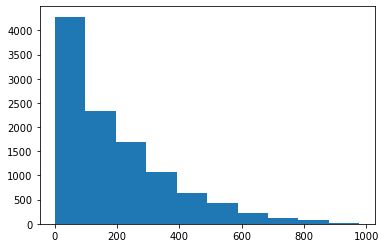

In [29]:
plt.hist(train['count'])

###### count의 수치가 편중되어 있으므로 모델링 전 로그화 필요

(array([ 237.,  462.,  625.,  626.,  805., 1076., 1768., 2544., 2058.,
         685.]),
 array([0.69314718, 1.31238343, 1.93161968, 2.55085593, 3.17009218,
        3.78932843, 4.40856467, 5.02780092, 5.64703717, 6.26627342,
        6.88550967]),
 <a list of 10 Patch objects>)

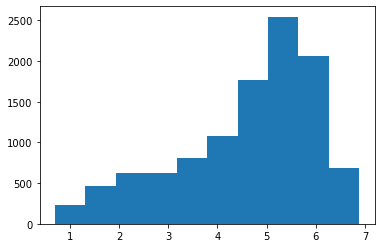

In [30]:
train['count_log']=np.log1p(train['count'])
plt.hist(train['count_log'])

In [31]:
#모델링을 위해 독립변수, 종속변수 분리
y_train=train['count_log']
train.drop(['count','count_log'], axis=1, inplace=True)

In [43]:
#xgboost를 이용한 회귀 분석
model= XGBRegressor(n_estimators=499,
                    max_depth=10,
                   learning_rate = 0.021766,
                   subsample = 0.216936,
                   colsample_bytree = 0.924414,
                   colsample_bylevel = 0.816317,
                   seed=37,
                   gamma=0.5
                   )
model.fit(train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.816317,
             colsample_bynode=1, colsample_bytree=0.924414, gamma=0.5,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.021766, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=499, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=37, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=37, subsample=0.216936,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
#로그를 역산하여 count로 저장
y_pred=model.predict(test)
test['count']=np.exp(y_pred) -1

In [45]:
# 결과 CSV 저장
sample = pd.read_csv('./data_bike/sampleSubmission.csv')
sample['count'] = test['count']
test.drop(['count'], axis=1, inplace=True)
sample.to_csv('./data_bike/result.csv', index=False)